本笔记寻找适合中概股的择时策略。
采用2006至2016的数据进行回测和优化，然后观察2017~2021的表现。
将尝试和比较多种不同的这时策略。




In [2]:
# all imports and setups here
import yfinance as yf
import numpy as np
import pyfolio as pf
import backtrader as bt
import warnings
import matplotlib as plt
from IPython.core.debugger import set_trace
import strategies as st



warnings.filterwarnings('ignore')


C:\Users\xiaoyi\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


首先是买入并持有的表现。

Start date,2012-01-03
End date,2021-09-17
Total months,116
,Backtest
Annual return,4.5%
Cumulative returns,52.9%
Annual volatility,23.5%
Sharpe ratio,0.30
Calmar ratio,0.10
Stability,0.62
Max drawdown,-45.5%


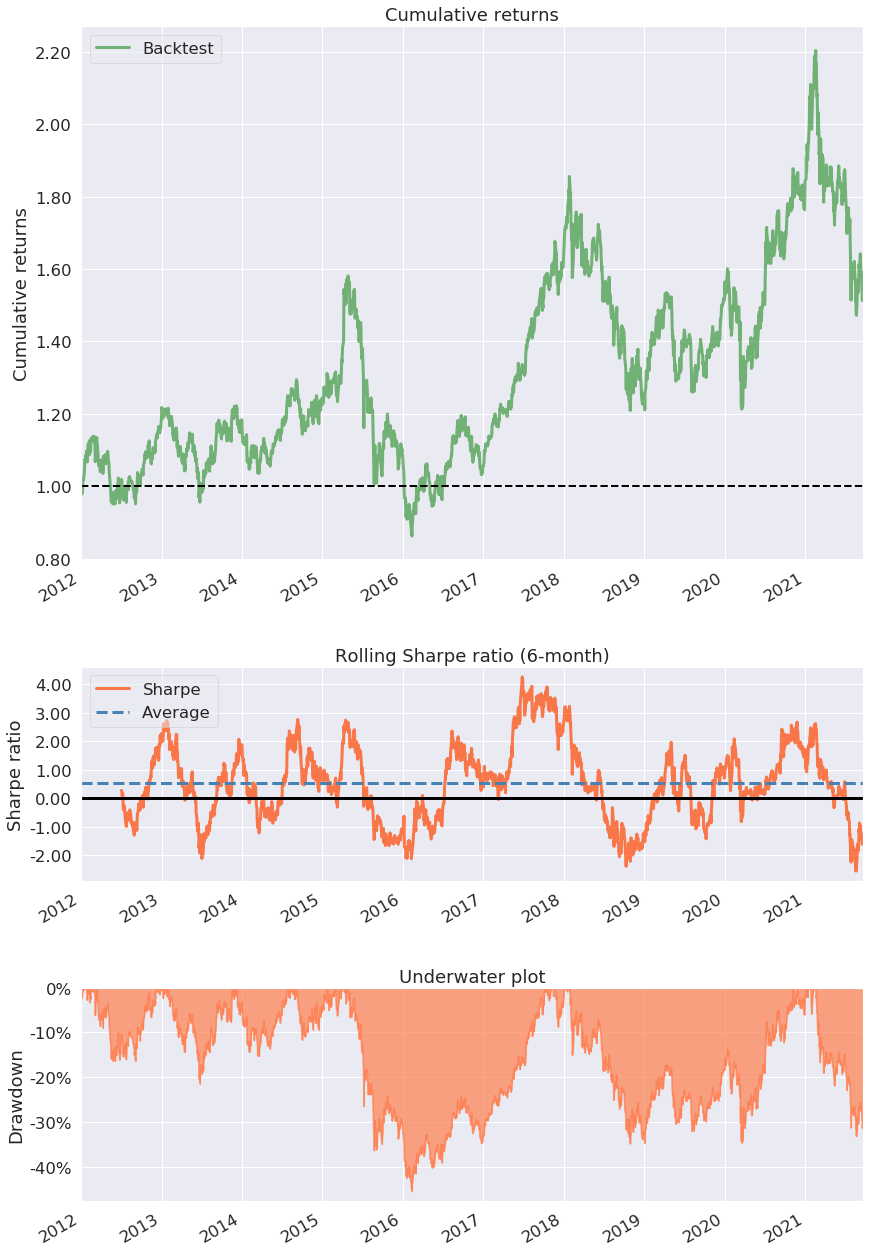

In [3]:
ticker=yf.Ticker('MCHI')
stock_prices=ticker.history(start='2012-01-01',end='2021-12-31')
buyandhold_returns=np.log(stock_prices.Close/stock_prices.Close.shift(1))
pf.create_simple_tear_sheet(buyandhold_returns)


第一个择时策略是简单的均线交叉策略：
1. 快速均线上穿慢速均线时做多
2. 快算均线下穿慢速均线时清仓

In [4]:
def printTradeAnalysis(analyzer):
    '''
    Function to print the Technical Analysis results in a nice format.
    '''
    #Get the results we are interested in
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total,2)
    strike_rate = (total_won / total_closed) * 100
    #Designate the rows
    h1 = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
    h2 = ['Strike Rate','Win Streak', 'Losing Streak', 'PnL Net']
    r1 = [total_open, total_closed,total_won,total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    #Check which set of headers is the longest.
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    #Print the rows
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("Trade Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))

In [5]:
class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        printlog=False, #控制全局是否输出Log
        fast_days=10,  # period for the fast moving average
        slow_days=30,   # period for the slow moving average
        buffer=0.05,
    )

    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:            
            dt = dt or self.datas[0].datetime.date(0)           
            print('%s, %s' % (dt.isoformat(), txt)) 
    
    def notify_order(self, order):        
        if order.status in [order.Submitted, order.Accepted]:            
            return

        if order.status in [order.Completed]:            
            if order.isbuy():               
                self.log(                    
                'BUY EXECUTED, Price: %.2f, Quantity: %.2f, Cost: %.2f, Comm %.2f' %                   
                (order.executed.price,
                order.executed.size,
                order.executed.value,
                order.executed.comm))              
                self.buyprice = order.executed.price              
                self.buycomm = order.executed.comm            
            else:             
                self.log('SELL EXECUTED, Price: %.2f, Quantity: %.2f, Cost: %.2f, Comm %.2f' %                        
                     (order.executed.price,
                     order.executed.size,
                     order.executed.value,
                     order.executed.comm))                             
                self.bar_executed = len(self)       
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:           
            self.log('Order Canceled/Margin/Rejected') 

    def __init__(self):
        fast_sma = bt.ind.SMA(period=self.p.fast_days)  # fast moving average
        slow_sma = bt.ind.SMA(period=self.p.slow_days)  # slow moving average
        self.sma_crossover = bt.ind.CrossOver(fast_sma, slow_sma)  # crossover signal
        self.trade_signal=self.sma_crossover

    def next(self):
        if self.trade_signal > 0:
            self.buy() 

        elif self.trade_signal < 0:  # in the market & cross to the downside
            self.sell() 
    
       
   

In [6]:
class SmaCrossStop(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        printlog=False, #控制全局是否输出Log
        fast_days=10,  # period for the fast moving average
        slow_days=30   # period for the slow moving average
    )

    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:            
            dt = dt or self.datas[0].datetime.date(0)           
            print('%s, %s' % (dt.isoformat(), txt)) 
    
    def notify_order(self, order):        
        if order.status in [order.Submitted, order.Accepted]:            
            return

        if order.status in [order.Completed]:            
            if order.isbuy():               
                self.log(                    
                'BUY EXECUTED, Price: %.2f, Quantity: %.2f, Cost: %.2f, Comm %.2f' %                   
                (order.executed.price,
                order.executed.size,
                order.executed.value,
                order.executed.comm))              
                self.buyprice = order.executed.price              
                self.buycomm = order.executed.comm            
            else:             
                self.log('SELL EXECUTED, Price: %.2f, Quantity: %.2f, Cost: %.2f, Comm %.2f' %                        
                     (order.executed.price,
                     order.executed.size,
                     order.executed.value,
                     order.executed.comm))                             
                self.bar_executed = len(self)       
        elif order.status in [order.Canceled, order.Rejected]:           
            self.log('Order Canceled/Rejected') 
        elif order.status in [order.Margin]:           
            self.log('Order Margin',doprint=True) 

    def __init__(self):
        fast_sma = bt.ind.SMA(period=self.p.fast_days)  # fast moving average
        slow_sma = bt.ind.SMA(period=self.p.slow_days)  # slow moving average
        self.sma_crossover = bt.ind.CrossOver(fast_sma, slow_sma)  # crossover signal
        self.trade_signal=self.sma_crossover
        self.stopprice=0
        self.buyprice=0

    def next(self):

        #入场
        if not self.position:  # not in the market
            if self.trade_signal > 0:
                self.buy()
        #出场
        elif self.trade_signal < 0:  # in the market & cross to the downside
            self.close()  # close long position
        #止损
        self.stopprice=max(self.buyprice*0.8,self.datas[0].close*0.8,self.stopprice)
        if self.datas[0].close<self.stopprice:
            self.close()


In [7]:
# 创建主控制器    
cerebro = bt.Cerebro()    
    

#准备回测数据
data=bt.feeds.PandasData(dataname=stock_prices,plot=True)
cerebro.adddata(data)
   
    
# broker设置资金、手续费
cerebro.broker.setcash(1000000.0)    
cerebro.broker.setcommission(commission=0.001)
#cerebro.broker.set_checksubmit(checksubmit=True)

print('Starting Portfolio Value: %.2f, Cash: %.2f' % (cerebro.broker.getvalue(),cerebro.broker.getcash()))  


# Analyzers
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,_name='mytrades')
#Observers

            
# 加入策略 
cerebro.addsizer(AllInLongOnly)
cerebro.addstrategy(SmaCross,printlog=False,fast_days=10,slow_days=20) 



# 启动回测    
thestrats=cerebro.run() #参数stdstats控制是否显添加默认的observer
thestrat = thestrats[0] 

print('End Portfolio Value: %.2f, Cash: %.2f' % (cerebro.broker.getvalue(),cerebro.broker.getcash()))  

#保持测试结果到CSV
pyfoliozer = thestrat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.to_csv('./output/test_returns.csv')
transactions.to_csv('./output/test_transactions.csv')

sma_returns=returns

mytrades=thestrat.analyzers.getbyname('mytrades')
analyzer=mytrades.get_analysis()
printTradeAnalysis(analyzer=analyzer)
 

Starting Portfolio Value: 1000000.00, Cash: 1000000.00


NameError: name 'AllInLongOnly' is not defined

<IPython.core.display.Javascript object>

[[<Figure size 1080x720 with 5 Axes>]]

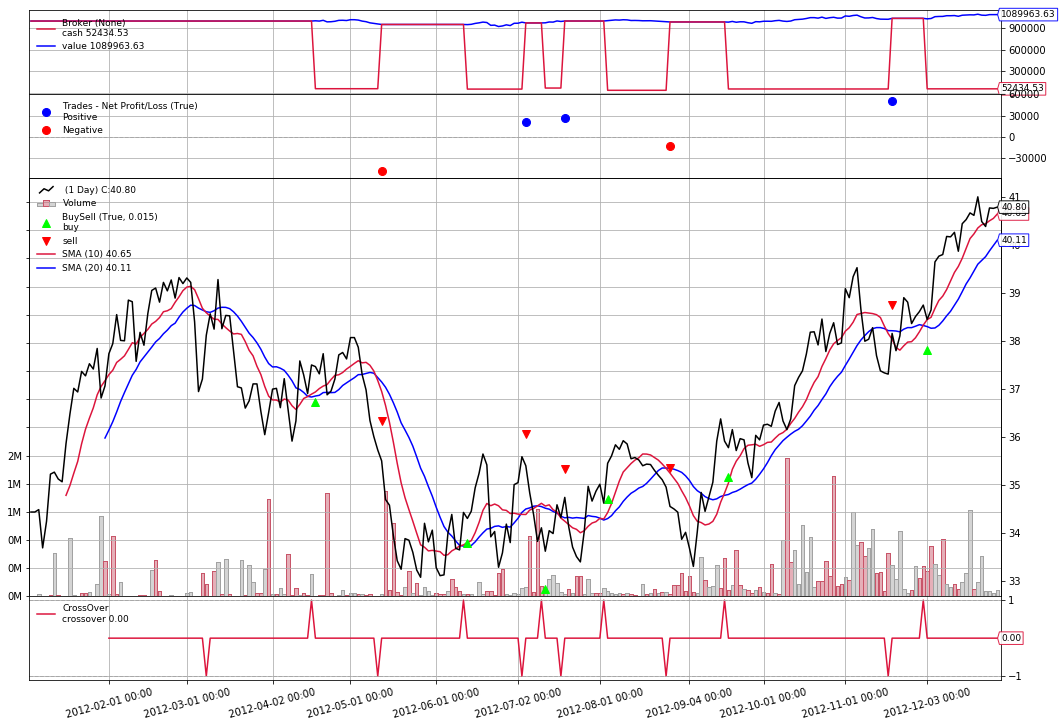

In [ ]:
#Plotting the result
plt.rcParams['figure.figsize'] = [15, 10]
cerebro.plot()

In [ ]:
#数据比较
#pf.show_perf_stats(buyandhold_returns)
#pf.show_perf_stats(sma_returns)
#pf.create_full_tear_sheet(returns=sma_returns.tz_localize(None),benchmark_rets=buyandhold_returns.tz_localize(None))
import empyrical
import prettytable
table=prettytable.PrettyTable(['Strategy','Annual Return','Sharp Ratio','Max Drawdown','Volatility'])
table.add_row(['Buy and Hold',
            empyrical.annual_return(buyandhold_returns),
            empyrical.sharpe_ratio(buyandhold_returns),
            empyrical.max_drawdown(buyandhold_returns),
            empyrical.annual_volatility(buyandhold_returns)])
empyrical.max_drawdown(sma_returns)
table.add_row(['SMA',
            empyrical.annual_return(sma_returns),
            empyrical.sharpe_ratio(sma_returns),
            empyrical.max_drawdown(sma_returns),
            empyrical.annual_volatility(sma_returns)])
print(table)


+--------------+---------------------+--------------------+----------------------+---------------------+
|   Strategy   |    Annual Return    |    Sharp Ratio     |     Max Drawdown     |      Volatility     |
+--------------+---------------------+--------------------+----------------------+---------------------+
| Buy and Hold | 0.16112920112885099 | 0.8198868404120223 | -0.16392534521000424 | 0.20970808449404071 |
|     SMA      | 0.09109546936887236 | 0.8139419148920445 | -0.09351691721905835 |  0.1152589972123176 |
+--------------+---------------------+--------------------+----------------------+---------------------+


简单均线交叉策略，收益大幅跑输买入并持有，只是降低了波动率和最大回测。下一步的优化思路：
1. 加入止损
2. 优化均线参数

2012-04-18, Order Margin
End Portfolio Value: 1070130.33, Cash: 146141.54
Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               0              1              0              1              
               Strike Rate    Win Streak     Losing Streak  PnL Net        
               0.0            0              1              -47960.75      


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[<Figure size 1080x720 with 5 Axes>],
 [<Figure size 1080x720 with 5 Axes>],
 [<Figure size 1080x720 with 5 Axes>]]

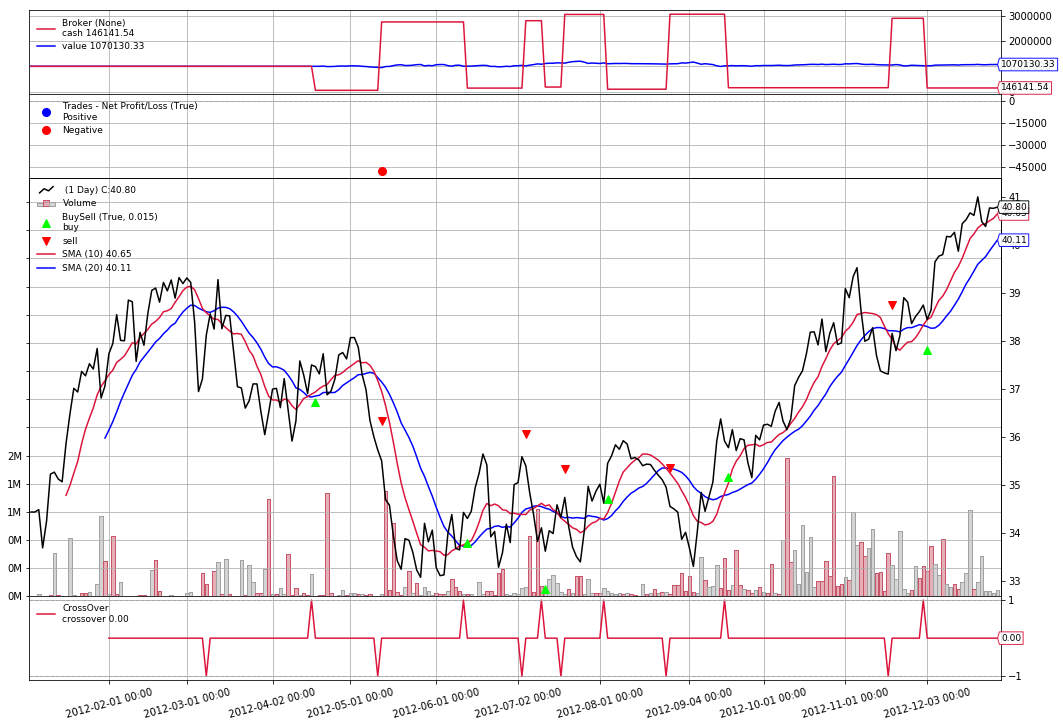

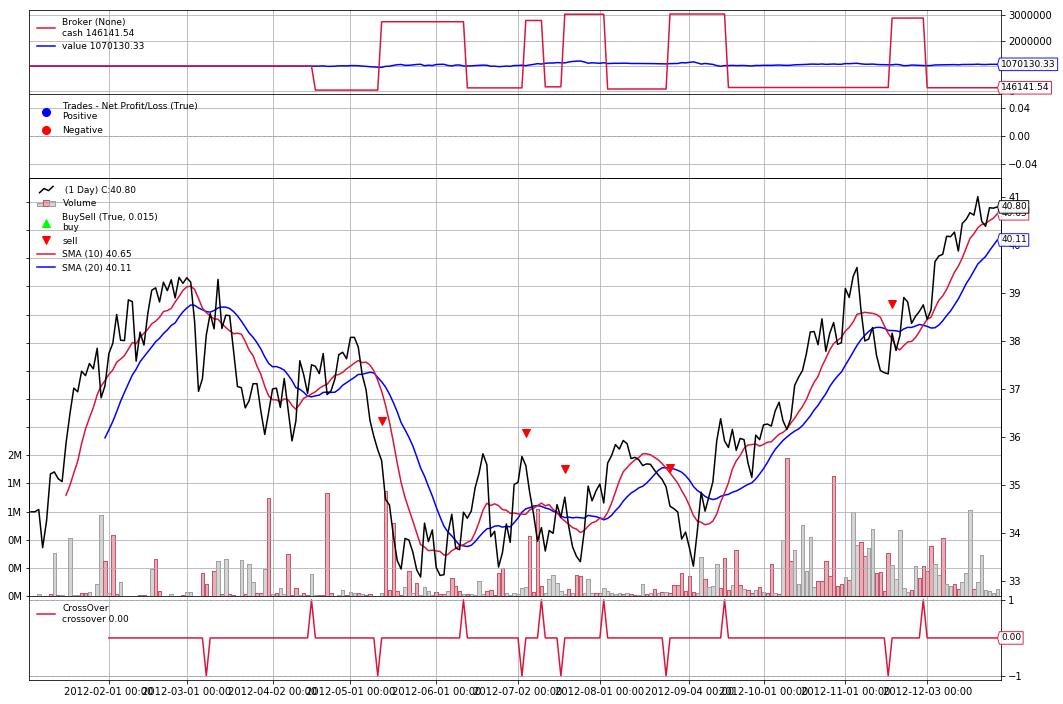

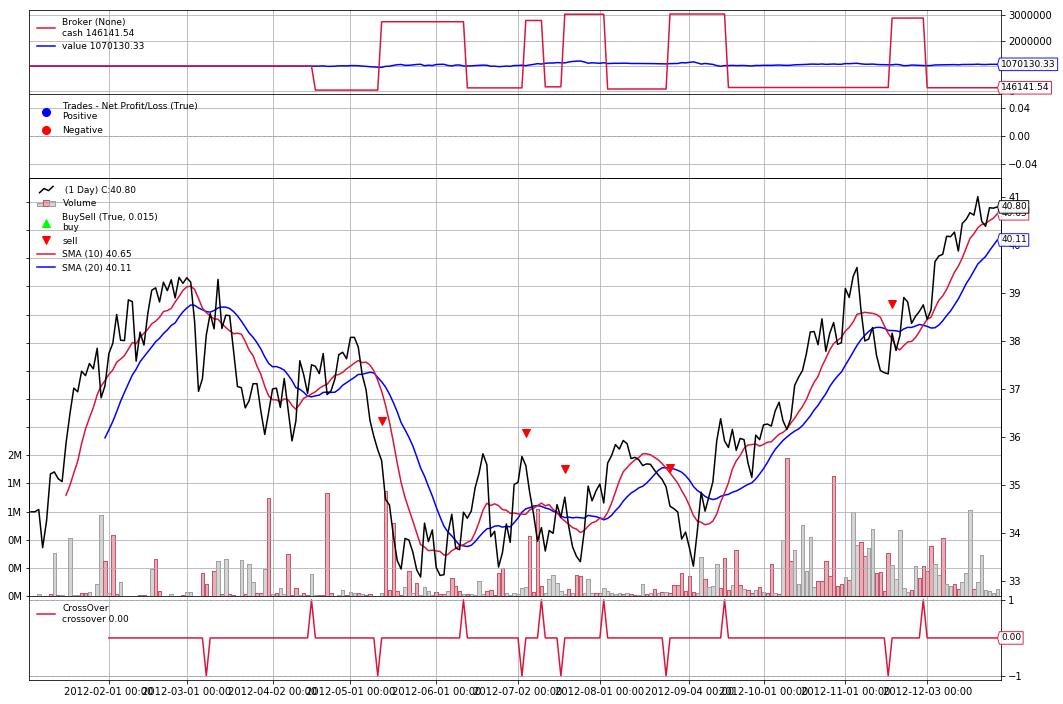

In [ ]:
cerebro.addstrategy(SmaCrossStop,printlog=False,fast_days=10,slow_days=20) 
thestrats=cerebro.run() #参数stdstats控制是否显添加默认的observer
thestrat = thestrats[0] 

print('End Portfolio Value: %.2f, Cash: %.2f' % (cerebro.broker.getvalue(),cerebro.broker.getcash()))  

#保持测试结果到CSV
pyfoliozer = thestrat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.to_csv('./output/test_returns.csv')
transactions.to_csv('./output/test_transactions.csv')

smastop_returns=returns

mytrades=thestrat.analyzers.getbyname('mytrades')
analyzer=mytrades.get_analysis()
printTradeAnalysis(analyzer=analyzer)
cerebro.plot()


In [ ]:
table.add_row(['SMAStop',
            empyrical.annual_return(smastop_returns),
            empyrical.sharpe_ratio(smastop_returns),
            empyrical.max_drawdown(smastop_returns),
            empyrical.annual_volatility(smastop_returns)])
print(table)

+--------------+---------------------+--------------------+----------------------+---------------------+
|   Strategy   |    Annual Return    |    Sharp Ratio     |     Max Drawdown     |      Volatility     |
+--------------+---------------------+--------------------+----------------------+---------------------+
| Buy and Hold | 0.16112920112885099 | 0.8198868404120223 | -0.16392534521000424 | 0.20970808449404071 |
|     SMA      | 0.09109546936887236 | 0.8139419148920445 | -0.09351691721905835 |  0.1152589972123176 |
|   SMAStop    | 0.09109546936887236 | 0.8139419148920445 | -0.09351691721905835 |  0.1152589972123176 |
+--------------+---------------------+--------------------+----------------------+---------------------+
